7.484982273252969 [3 6 0 0 0 0 0 0 3 4 6] 0.0 2


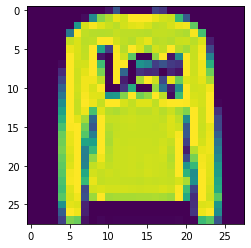

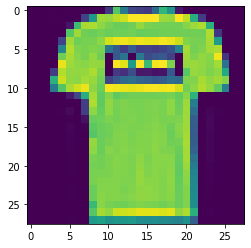

5.890825271217032 [6 6 0 5 5 6 4 4 6 2 0] 6.0 1


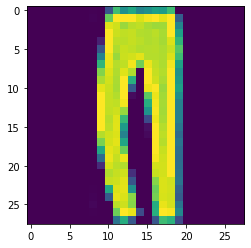

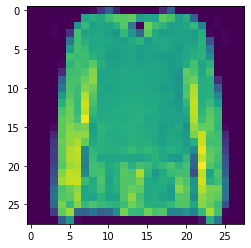

6.285295876266343 [1 1 1 1 1 1 1 1 1 1 1] 1.0 1
8.289753637997967 [0 6 0 6 0 0 0 0 0 0 0] 0.0 6


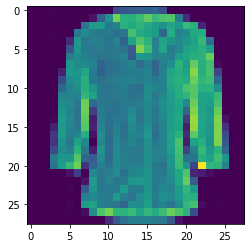

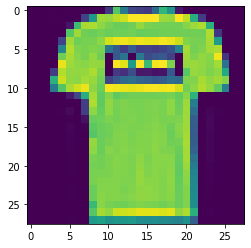

6.448711681641627 [1 5 0 1 5 5 5 1 1 0 5] 5.0 1


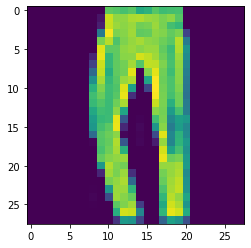

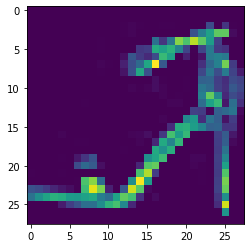

8.154917754535433 [2 4 2 6 4 2 6 2 4 2 6] 2.0 4


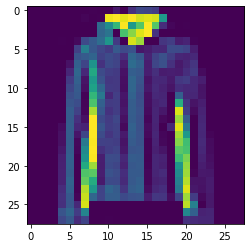

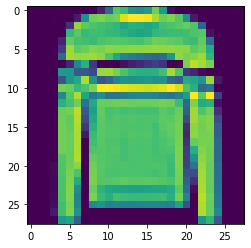

In [ ]:
#RF version 2.1
%tensorflow_version 2.x
import tensorflow as tf
tf.__version__

import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt

# Download Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(trImages, trLabels), (tImages, tLabels) = fashion_mnist.load_data()


#print some information
# Download Fashion MNIST dataset
fashion_mnist = keras.datasets.fashion_mnist
(trImages, trLabels), (tImages, tLabels) = fashion_mnist.load_data()


#print out pictures, but it works
paramk = 11 # parameter k of k-nearest neighbors
numTrainImages = np.shape(trLabels)[0] # so many train images
numTestImages = np.shape(tLabels)[0] # so many test images

arrayKNNLabels = np.array([])
for iTeI in range(1,numTestImages):
  arrayL2Norm = np.array([]) # store distance of a test image from all train images
  for jTrI in range(numTrainImages):  
    l2norm = np.sum(((trImages[jTrI]-tImages[iTeI])/255.0)**2)**(0.5) # distance between two images; 255 is max. pixel value ==> normalization   
    arrayL2Norm = np.append(arrayL2Norm, l2norm)
    
  sIndex = np.argsort(arrayL2Norm) # sorting distance and returning indices that achieves sort
  
  kLabels = trLabels[sIndex[0:paramk]] # choose first k labels  
  (values, counts) = np.unique(kLabels, return_counts=True) # find unique labels and their counts
  arrayKNNLabels = np.append(arrayKNNLabels, values[np.argmax(counts)])
  print(arrayL2Norm[sIndex[0]], kLabels, arrayKNNLabels[-1], tLabels[iTeI])
  
  if arrayKNNLabels[-1] != tLabels[iTeI]:

    plt.figure(1)
    plt.imshow(tImages[iTeI])
    plt.draw()
    
    for i in range(numTrainImages):
      if trLabels[i] == arrayKNNLabels[-1]:
        plt.figure(2)
        plt.imshow(trImages[i])
        plt.draw()
        break
  
    plt.show()
    
    
    
#last two code does not work, maybe Tensorflow version need to be change
'''
first code don't work
'''
paramk = 11 # parameter k of k-nearest neighbors
numTrainImages = np.shape(trLabels)[0] # so many train images
numTestImages = np.shape(tLabels)[0] # so many test images

arrayKNNLabels = np.array([])
numErrs = 0
for iTeI in range(0,numTestImages):
  arrayL2Norm = np.array([]) # store distance of a test image from all train images
  
  tmpTImage = np.copy(tImages[iTeI])
  tmpTImage[tmpTImage > 0] = 1
  
  for jTrI in range(numTrainImages):
    tmpTrImage = np.copy(trImages[jTrI])
    tmpTrImage[tmpTrImage>0] = 1
    
    
    l2norm = np.sum(((tmpTrImage-tmpTImage)**2)**(0.5)) # distance between two images; 255 is max. pixel value ==> normalization 
    if jTrI == 0:
      with tf.Session() as sess:
        print(tf.count_nonzero(tmpTrImage-tmpTImage, axis=[0,1]).eval())      
      print(iTeI, jTrI, l2norm)
    arrayL2Norm = np.append(arrayL2Norm, l2norm)
    
  sIndex = np.argsort(arrayL2Norm) # sorting distance and returning indices that achieves sort
  
  kLabels = trLabels[sIndex[0:paramk]] # choose first k labels  
  (values, counts) = np.unique(kLabels, return_counts=True) # find unique labels and their counts
  arrayKNNLabels = np.append(arrayKNNLabels, values[np.argmax(counts)])
   
  if arrayKNNLabels[-1] != tLabels[iTeI]:
    numErrs += 1
    print(numErrs,"/",iTeI)
print("# Classification Errors= ", numErrs, "% accuracy= ", 100.*(numTestImages-numErrs)/numTestImages)


'''
second code don't work
'''
paramk = 11 # parameter k of K-nearest neighbors

# Defining KNN Graph with L0 Norm
x = tf.placeholder(trImages.dtype, shape=trImages.shape) # all train images, i.e., 60000 x 28 x 28
y = tf.placeholder(tImages.dtype, shape=tImages.shape[1:]) # a test image, 28 x 28

xThresholded = tf.clip_by_value(tf.cast(x, tf.int32), 0, 1) # x is int8 which is not supported in many tf functions, hence typecast
yThresholded = tf.clip_by_value(tf.cast(y, tf.int32), 0, 1) # clip_by_value converts dataset to tensors of 0 and 1, i.e., 1 where tensor is non-zero
computeL0Dist = tf.count_nonzero(xThresholded - yThresholded, axis=[1,2]) # Computing L0 Norm by reducing along axes
findKClosestTrImages = tf.contrib.framework.argsort(computeL0Dist, direction='ASCENDING') # sorting (image) indices in order of ascending metrics, pick first k in the next step
findLabelsKClosestTrImages = tf.gather(trLabels, findKClosestTrImages[0:paramk]) # doing trLabels[findKClosestTrImages[0:paramk]] throws error, hence this workaround
findULabels, findIdex, findCounts = tf.unique_with_counts(findLabelsKClosestTrImages) # examine labels of k closest Train images
findPredictedLabel = tf.gather(findULabels, tf.argmax(findCounts)) # assign label to test image based on most occurring labels among k closest Train images

# Let's run the graph
numErrs = 0
numTestImages = np.shape(tLabels)[0]
numTrainImages = np.shape(trLabels)[0] # so many train images

with tf.Session() as sess:
  for iTeI in range(0,numTestImages): # iterate each image in test set
    predictedLabel = sess.run([findPredictedLabel], feed_dict={x:trImages, y:tImages[iTeI]})   

    if predictedLabel == tLabels[iTeI]:
      numErrs += 1
      print(numErrs,"/",iTeI)
      print("\t\t", predictedLabel[0], "\t\t\t\t", tLabels[iTeI])
      
      if (1):
        plt.figure(1)
        plt.subplot(1,2,1)
        plt.imshow(tImages[iTeI])
        plt.title('Test Image has label %i' %(predictedLabel[0]))
        
        for i in range(numTrainImages):
          if trLabels[i] == predictedLabel:
            plt.subplot(1,2,2)
            plt.imshow(trImages[i])
            plt.title('Correctly Labeled as %i' %(tLabels[iTeI]))
            plt.draw()
            break
        plt.show()

print("# Classification Errors= ", numErrs, "% accuracy= ", 100.*(numTestImages-numErrs)/numTestImages)
